<a href="https://colab.research.google.com/github/ddinesan/Manga/blob/master/Lecture_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Superdense Communication and Quantum Teleportation

This is a worksheet prepared by Nadine  for Lecture 8 of the reading course "Introduction to Quantum Computer Programming" (AMATH 900/ AMATH 495/ QIC 895) at the University of Waterloo.

Course Webpage: https://sites.google.com/view/quantum-computer-programming

Text followed in the course: [Quantum Computing, An Applied Approach](https://www.springer.com/gp/book/9783030239213) by Jack D. Hidary (2019)

In this notebook we will use Cirq to create and simulate the *superdense coding circuit* and the *quantum teleportation circuit* (see J. D. Hidary, "Quantum Computing: An Applied Approach", p. 85 - 88).

### Installing and Importing Cirq

In [ ]:
!pip install cirq qutip

import random 
import cirq
import qutip
import numpy as np
from cirq.circuits import InsertStrategy

# Define a function to print circuits nicely (see Lecture 1)
from cirq.contrib.svg import circuit_to_svg
from IPython.display import SVG, display
import os

def cprint(circuit):
  """Convert the cirq.Circuit to a temp svg and display + garbage collect."""
  with open("temp.svg", 'w+') as f:
    f.write(circuit_to_svg(circuit))
  display(SVG('temp.svg'))
  os.remove('temp.svg')

## Superdense Coding

The task of superdense coding is the following: Alice has two bits $a$ and $b$ (i.e., $ab \in \{00,01,10,11\}$), which she wants to communicate to Bob by sending him a single qubit.

The task can be performed if Alice and Bob share an EPR pair (qubit $A$ is with Alice and qubit $B$ is with Bob). Alice performs operations $Z^a X^b$ on her qubit, then sends it over to Bob. Bob measures both qubits in the Bell basis. His measurement results $(a,b)$ are identical to Alice's bits $a$ and $b$. The quantum circuit looks as follows:

![](https://drive.google.com/uc?id=1xSWhaFfNCgkj0Djeyd850C0IA7iBN6Rw)

Let us now simulate superdense communication in Cirq:

Alice's sent message: 1 1

Circuit:


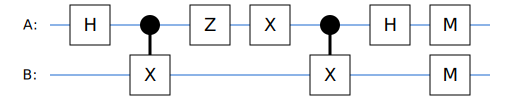


Bob's received message: 1 1

The two bits were successfully communicated from Alice to Bob.


In [ ]:
# Create qubits A and B
A = cirq.NamedQubit("A")
B = cirq.NamedQubit("B")
circuit = cirq.Circuit()

# Put A and B into Bell state
circuit.append([cirq.H(A),cirq.CNOT(A, B)])

# Alice picks the two bit message she wants to send to Bob
a = 1
b = 1

# Print Alice's message
print("Alice's sent message:", a,b)

# Alice encodes her message with the appropriate quantum operations on qubit A
circuit.append([cirq.Z(A)**a, cirq.X(A)**b])

# At this point, Alice sends her qubit over to Bob. This is not reflected in the circuit.
# Bob measures in the Bell basis
circuit.append([cirq.CNOT(A, B), cirq.H(A), cirq.measure(A, key='A'), cirq.measure(B, key='B')], strategy=InsertStrategy.INLINE)

# Print out the circuit
print("\nCircuit:")
cprint(circuit)

# Run the quantum circuit on a simulator backend
simulator = cirq.Simulator()
result = simulator.run(circuit)

a_received = result.measurements['A'][0]
b_received = result.measurements['B'][0]

# Print Bob’s received message
print("\nBob's received message:", a_received[0] , b_received[0])

if a==a_received and b==b_received: 
  print('\nThe two bits were successfully communicated from Alice to Bob.')
else:
  print('The communication of bits a and b from Alice to Bob was unsuccessful.')

##Quantum Teleportation

The task of quantum teleportation is the following: Alice wants to communicate the state $|\psi\rangle$ of a qubit $Q$ to Bob, using only classical communication. The quantum teleportation protocol can be realized via the following quantum circuit:

![alt text](https://drive.google.com/uc?id=1YcbyTsirNv_60-135gfgQVcxECuZ7U1R)

Here we demonstrate how to simulate the quantum teleportation circuit in Cirq. 
First, let us define a function that returns a quantum teleportation circuit:



In [ ]:
def make_quantum_teleportation_circuit(ranX, ranY):
    
    # Create three qubits (Q to be teleported, A is Alice's qubit, B is Bob's qubit):
    Q , A, B = cirq.LineQubit.range(3)

    # Create circuit and put Q into some random state
    circuit = cirq.Circuit()
    circuit.append([cirq.X(Q)**ranX, cirq.Y(Q)**ranY])

    # To see the state we prepared Q in, simulate circuit and store result in "message"
    simulator = cirq.Simulator()
    message = simulator.simulate(circuit)
    
    # Create Bell state between qubits A and B
    circuit.append([cirq.H(A), cirq.CNOT(A,B)])
    
    # Alice performs Bell measurement on Q and A 
    circuit.append([cirq.CNOT(Q,A), cirq.H(Q), cirq.measure(Q,A)])
    
    # Q and A now represent two classical bits, q and a. Bob uses these to perform (Z^q)(X^a) on his qubit B
    circuit.append([cirq.CNOT(A,B), cirq.CZ(Q,B)])

    return message, circuit

Now let us create two random numbers and use them as input for our `make_quantum_teleportation_circuit` function. Then we print the Bloch vector of the state *of* qubit $Q$ (the state Alice wants to communicate to Bob). To verify whether the teleportation was successful, we also print the Bloch vector of the final state of qubit B (the state Bob's qubit ends up in). 



Bloch vector of Q:   q = [qx, qy, qz] =  [ 0.7324, -0.244 ,  0.6357] 



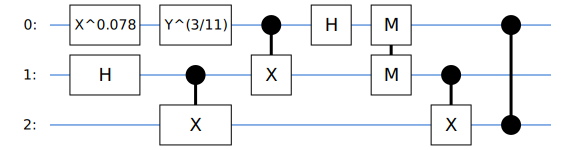


Final Bloch vector of B:   b = [bx, by, bz] =  [ 0.7324, -0.244 ,  0.6357] 

The state of qubit Q was successfully teleported from Alice to Bob.


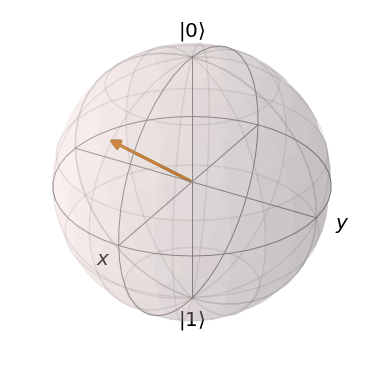

In [ ]:
# Create two random numbers between 0 and 1
ranX = random.random()
ranY = random.random()

# Create the teleportation circuit
message, circuit = make_quantum_teleportation_circuit(ranX, ranY)
    
q = np.round_(cirq.bloch_vector_from_state_vector(message.final_state, 0),4)
print("Bloch vector of Q:  ", "q = [qx, qy, qz] = ", np.array2string(q,separator=', '), '\n')
BSphere = qutip.Bloch()
BSphere.add_vectors(q)

cprint(circuit)
    
simulator = cirq.Simulator()
received = simulator.simulate(circuit)

b = np.round_(cirq.bloch_vector_from_state_vector(received.final_state, 2),4)
print("\nFinal Bloch vector of B:  ","b = [bx, by, bz] = ", np.array2string(b,separator=', '), '\n')
BSphere.add_vectors(b)
BSphere.show()

if (q==b).any(): 
  print('The state of qubit Q was successfully teleported from Alice to Bob.')
else:
  print('The teleportation of qubit Q was unsuccessful.')